# halo EFT $n-\alpha$ scattering calculation from __C.A. Bertulani et al. NPA712(2002)37-58__

 $s_{1/2}$ non-resonant : LO treated as full summation
 
 $p_{3/2}$ -> resonance at E~1 MeV, shallow virtual bound state
                This requires new power counting. 
                Thus treat scattering length and effective range non-perturbatively.  
 
 $p_{1/2}$ non-resonant : At first look. because this channel does not have resonance,
                  it can be thought to be treated perturbatively. However, it was shown that 
                  we may need to treat this channel also non-perturbatively. 
 

## Import and define constants

In [78]:
import numpy
import numpy as np

import matplotlib.pyplot as plt

import scipy 
import scipy.special
from scipy.special import factorial

from sympy.physics.sho import E_nl
from sympy import symbols
from sympy.physics.sho import R_nl
from sympy import var
from sympy.physics.wigner import wigner_9j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import clebsch_gordan

from functools import lru_cache

hbarc = 197.326968 # MeV.fm 
amu = 931.4940954 # MeV
mass_p  = 938.272    
mass_n  = 939.5653
mass_N = (mass_p+mass_n)/2.0
alpha = 1.0/137.03599

mass_alpha = 3727.4 # MeV 

reduced_mass = mass_n*mass_alpha/(mass_n+mass_alpha)
fm = 1/hbarc # MeV^-1 

## ERE of Table 1.

ERE of n-alpha is already known as Table 1.  

The power counting scale estimation in the text below table 1.
(Be careful for the units)

We count 

natural S-wave case
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{hi} + \frac{1}{M_{hi}} k^2 +\frac{1}{M^3_{hi}} k^4$

unnatural S-wave case 
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{lo} + \frac{1}{M_{hi}} k^2 +\frac{1}{M^3_{hi}} k^4$

natural P-wave case
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{hi}^3 + M_{hi} k^2 +\frac{1}{M_{hi}} k^4$

unnatural P-wave case 
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{lo}^3 + M_{lo} k^2 +\frac{1}{M_{hi}} k^4$



In [138]:
#----------ERE data
ERE_data={'0+': [2.4641*fm, 1.385*fm,0.0], '1-':[-13.821*fm**3,-0.419*fm**(-1),0.0],'1+':[-62.951*fm**3,-0.8819*fm**(-1),-3.002*fm]}

# scale estimation
print('**M_{lo} and M_{hi} estimation (MeV) from ERE ')
print('0+ channel = ',1/(ERE_data['0+'][0]), 1/(ERE_data['0+'][1]/2) )
print('1+ channel = ', 1/(-ERE_data['1+'][0])**(1./3), (-ERE_data['1+'][1]/2), 1/(-ERE_data['1+'][2]/4)  )
print('1- channel = ',1/(-ERE_data['1-'][0])**(1/3), (-ERE_data['1-'][1]/2) )

**M_{lo} and M_{hi} estimation (MeV) from ERE 
0+ channel =  80.08074672294143 284.94869025270754
1+ channel =  49.60425122682985 87.0113265396 262.92733910726184
1- channel =  82.22551845682871 41.339999795999994


## Phase shift of 1+ channel Fig. 4
Phase shift extracted as eq.(24)

$ \delta_{l} = \frac{1}{2 i}\log (1+2ik*f_l) $

where $f_{l}$ partial wave scattering amplitudes  eq.(30)

LO amplitudes from eq.(46) , NLO amplitudes from eq.(49)

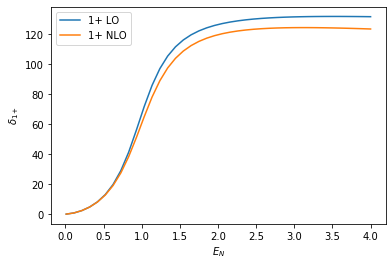

In [80]:
# 1+ phase shift 
a = ERE_data['1+'][0]  # to MeV units
r = ERE_data['1+'][1]     # to MeV units
P = ERE_data['1+'][2]     # to MeV units   

# in lab frame energy 
E_lab = np.linspace(0.01,4,40) 
E_cm =  reduced_mass/mass_n*E_lab
k_list = np.sqrt(2*reduced_mass*E_cm)

# scattering Amplitudes ( f_{1+} )
f_LO = k_list**2/(-1./a+r/2*k_list**2-1j*k_list**3)
f_NLO= P/4.0*k_list**6/(-1./a+r/2*k_list**2-1j*k_list**3)**2

# LO phase shift
temp=1+2*1j*k_list*f_LO
delta = np.log(temp)/(2*1j)*180/np.pi 
for i in range(len(delta)):
    if delta[i]<0:
        delta[i]=delta[i]+180
delta_LO = delta

#NLO phase shift
temp=1+2*1j*k_list*(f_LO+f_NLO)
delta = np.log(temp)/(2*1j)*180/np.pi 
for i in range(len(delta)):
    if delta[i]<0:
        delta[i]=delta[i]+180
delta_NLO = delta
        
# plot as a function of neutron kinetic energy vs pahse shift 
plt.plot(E_lab,np.real(delta_LO),label='1+ LO' )
plt.plot(E_lab,np.real(delta_NLO),label='1+ NLO')
plt.xlabel(r'$E_N$')
plt.ylabel(r'$\delta_{1+}$')
plt.legend()

## poles of 1+ channel at LO
eq.(23)

In [81]:
# 1+ 
a = ERE_data['1+'][0]  # to MeV units
r = ERE_data['1+'][1]     # to MeV units
P = ERE_data['1+'][2]     # to MeV units   

# pole positions 
a1=abs(a); r1=abs(r) ;

v = (108+a1*r1**3+108*np.sqrt(1+a1*(r1**3)/54))**(1./3)

gamma_1= (r1+a1**(1/3.)*r1**2/v+v/a1**(1./3) )/6.
gamma = (r1-a1**(1/3.)*r1**2/(2*v)-v/(2*a1**(1./3)) )/6.
gamma_t = -np.sqrt(3)/12*(a1**(1./3)*r1**2/v-v/a1**(1./3))
print('gamma_1=%f gamma=%f gamma_t=%f'%(gamma_1,gamma,gamma_t))

E0 = (gamma**2+gamma_t**2)/(2*reduced_mass)
Gamma = -4*gamma*np.sqrt(E0/(2*reduced_mass) )
print('E0=%f  Gamma(E0)=%f'%(E0,Gamma))

gamma_1=99.371692 gamma=-6.180183 gamma_t=34.497475
E0=0.818400  Gamma(E0)=0.577271


## Phase shift 0+ channel Fig.5

Question? 

eq.(47) seems to suggest f_{NLO}=-a  for 0+ channel.

However, the phase shift plot corresponds to f_{NLO}=1/(-1/a - i k) 


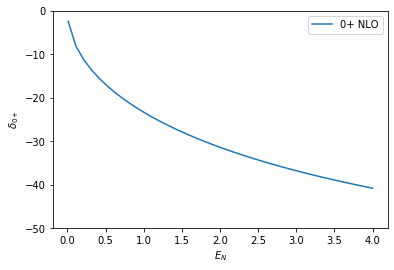

In [82]:
# 1+ phase shift 
a = ERE_data['0+'][0]  
r = ERE_data['0+'][1]  
P = ERE_data['0+'][2]  
# in lab frame energy 
E_lab = np.linspace(0.01,4,40) 
E_cm =  reduced_mass/mass_n*E_lab
k_list = np.sqrt(2*reduced_mass*E_cm)

# scattering Amplitudes ( f_{0+} )
#f_LO = 0.0
#f_NLO= -a

f_LO =0.0
f_NLO= 1/(-1/a-1j*k_list)

#f_LO =0.0
#f_NLO= -a*(1-1j*a*k_list)

#NLO phase shift
temp=1+2*1j*k_list*(f_LO+f_NLO)
delta = np.log(temp)/(2*1j)*180/np.pi 
delta_NLO = delta
        
# plot as a function of neutron kinetic energy vs pahse shift 
plt.plot(E_lab,np.real(delta_NLO),label='0+ NLO')
plt.xlabel(r'$E_N$')
plt.ylabel(r'$\delta_{0+}$')
plt.ylim([-50,0])
plt.legend()

## Phase shift 1- channel Fig. 8


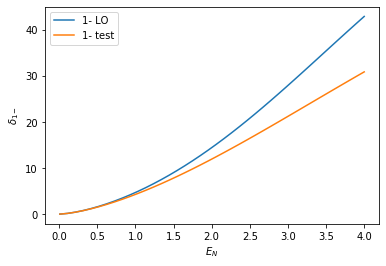

In [83]:
# 1+ phase shift 
a = ERE_data['1-'][0]  # to MeV units
r = ERE_data['1-'][1]     # to MeV units
P = ERE_data['1-'][2]     # to MeV units   

# in lab frame energy 
E_lab = np.linspace(0.01,4,40) 
E_cm =  reduced_mass/mass_n*E_lab
k_list = np.sqrt(2*reduced_mass*E_cm)

# scattering Amplitudes ( f_{1-} ) in modified power counting 
f_LO = k_list**2/(-1./a+r/2*k_list**2-1j*k_list**3)

# LO phase shift
temp=1+2*1j*k_list*f_LO
delta = np.log(temp)/(2*1j)*180/np.pi 
delta_LO = delta

# scattering Amplitudes ( f_{1-} ) in modified power counting 
f_test = k_list**2/(-1./a-1j*k_list**3)

# LO phase shift
temp=1+2*1j*k_list*f_test
delta = np.log(temp)/(2*1j)*180/np.pi 
delta_test = delta

# plot as a function of neutron kinetic energy vs pahse shift 
plt.plot(E_lab,np.real(delta_LO),label='1- LO' )
plt.plot(E_lab,np.real(delta_test),label='1- test' )
plt.xlabel(r'$E_N$')
plt.ylabel(r'$\delta_{1-}$')
plt.legend()

## Differential cross section Fig.7

Using general formula in the note for the differential cross section

$(\frac{d\sigma}{d\Omega})_{mm'}$

__Be careful for the notation of scipy for clebsch-gordan and spherical harmonics !!__

unpolarized cross section is 
$\frac{1}{2}\sum_{mm'}(\frac{d\sigma}{d\Omega})_{mm'}$


In [84]:
def scattering_amp(m,mp,theta,kcm):
    """
    n+alpha scattering amplitude
    
    Be careful that output is fm units  
    """
    # scattering Amplitudes f[L,J]
    f={}
    # 1+ channel amplitude 
    (a,r,P) = ERE_data['1+']
    f[1,1.5] = kcm**2/(-1./a+r/2*kcm**2-1j*kcm**3)+P/4.0*kcm**6/(-1./a+r/2*kcm**2-1j*kcm**3)**2
    # 1- channel 
    (a,r,P) = ERE_data['1-']
    f[1,0.5] = kcm**2/(-1./a+r/2*kcm**2-1j*kcm**3)
    # 0+ channel
    (a,r,P) = ERE_data['0+']
    f[0,0.5] = 1/(-1./a-1j*kcm)
    # sum over L,M,J
    sums =0.0
    for J in np.arange(0.5,1.5+1):
        for L in np.arange(0,1+1):
            factor = np.sqrt(4*np.pi*(2*L+1))*float(clebsch_gordan(L,0.5,J, 0,m,m))*float(clebsch_gordan(L,0.5,J, m-mp,mp,m))
            if abs(factor)>1.e-24:
                sums = sums + factor*scipy.special.sph_harm(m-mp,L, 0,theta)*f[L,J]
                #print(factor,scipy.special.sph_harm(m-mp,L,theta, 0),f[L,J]  )
    return sums*hbarc  #unit conversion             
                
def unpol_diff_cs(theta,kcm):
    """unpolarized differential cross section
       in unit of fm^2 
    """
    sums=0.0
    for m in [-0.5,0.5]:
        for mp in [-0.5,0.5]:
            sums = sums + np.abs(scattering_amp(m,mp,theta,kcm))**2
    return sums/2.0        
    

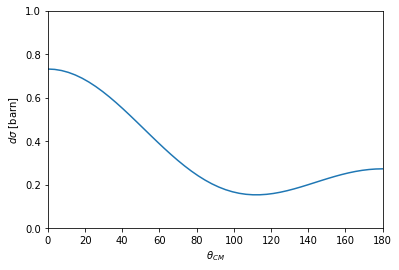

In [85]:
kcm=49.6 ;
thetaCM=np.linspace(0.0,np.pi,50)
ds=np.zeros(len(thetaCM))
for i in range(len(thetaCM)):
    ds[i]=unpol_diff_cs(thetaCM[i],kcm)
    
plt.plot(thetaCM*180/np.pi,ds/100.)   #into barn unit
plt.xlabel(r'$\theta_{CM}$')
plt.ylabel(r'$d\sigma$ [barn]')
plt.ylim([0,1]);
plt.xlim([0,180]);

## Total cross section:

One can obtain the total cross section by 

$\sigma_{T}=\frac{1}{2}\sum_{mm'}\int d\Omega \frac{d\sigma}{d\Omega}_{mm'}.$

But, it is more convenient to use optical theorem, eq. (31).
(Aactually,  eq.(26) is convenient for unpolarized differntial cross section). 


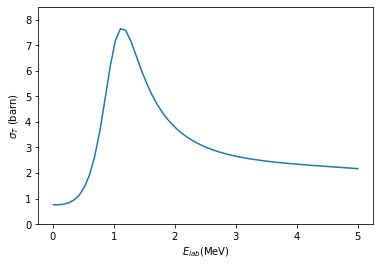

In [86]:
E_lab = np.linspace(0.01,5,60) 
E_cm =  reduced_mass/mass_n*E_lab
kcm = np.sqrt(2*reduced_mass*E_cm)
sig_tot= 4*np.pi/(kcm/hbarc)  *np.imag( scattering_amp(0.5,0.5,0.0,kcm) ) # m,mp is chosen arbitrary
plt.plot(E_lab,sig_tot/100)
plt.ylim([0,8.5])
plt.xlabel(r'$E_{lab}$(MeV)');
plt.ylabel(r'$\sigma_T$ (barn)');

## Coulomb scattering 

Oen needs

  1.  sigma_l(eta) : Coulomb phase shift

  2. C_l(eta) : Coulomb related factor

  3. h_l(eta) : Coulomb related function

  4. f_c(theta,eta) : Coulomb scattering amplitude 



In [87]:
def Coulomb_eta(charge_product,reduced_mass,pcm):
    """
        eta = Z1*Z2*alpha_em*(reduced_mass)/p 
    """
    return charge_product*alpha*(reduced_mass)/pcm 

def Coulomb_phaseshift(L,eta):
    return np.angle(scipy.special.gamma(L+1+1j*eta))

def Coulomb_factor(L,eta):
    """
    Gamow-Sommerfeld factor C_l(eta)**2
    """
    return np.exp(-np.pi*eta)*scipy.special.gamma(L+1+1j*eta)*scipy.special.gamma(L+1-1j*eta)

def Coulomb_h_l(L,eta,pcm):
    """
    h_l(eta)
    
    Note : not well defined numerically at eta =0.
    """
    temp=pcm**(2*L)*Coulomb_factor(L,eta)/Coulomb_factor(0,eta)
    out =temp*(scipy.special.digamma(1j*eta)+1./(2*1j*eta)-np.log(1j*eta))
    return out 

def Coulomb_scattering_amplitude(theta,eta,kcm):
    """
    Coulomb scattering amplitude for spin-less particle
    """
    temp1 = -eta/(2*kcm*np.sin(theta/2.0)**2)
    temp2 = np.exp(-1j*eta*np.log(np.sin(theta/2.0)**2)+2*1j* Coulomb_phaseshift(0,eta)   )
    return temp1*temp2

# alpha-12C scattering of Ando, Eur.Phys. J. A(2016) 52

Both particle are spinless. Thus simple. 

ERE para are set from Table 1, 2,3 choose first column only 

__However, there seems to be large cancellation maong terms and results are very sensitive to the approximations.__

Thus, though inaccurate, let us use approximation similar to the paper as possible.

## Basic parameters

In [140]:
# approximation .. 
mass_12C= 12*amu # amu or mass_N 

reduced_mass = mass_alpha*mass_12C/(mass_alpha+mass_12C);

ERE_data={'s': [0.034, 0.2693*fm,-0.0372*fm**3], 
          'p':[-3.84*10**(3), 0.405*fm**(-1),-0.645*fm],
          'd':[0.0 , 0.536*fm**(-3),-5.505*fm**(-1)]}

k_C = 2*6*alpha*reduced_mass
print(' k_C = ', k_C)

Talpha = np.linspace(0.1,7,100);
Ecm = reduced_mass/mass_alpha*Talpha;
kcm = np.sqrt(2*reduced_mass*Ecm); # kcm = sqrt(1.5*mu*T_alpha)

etas = Coulomb_eta(2*6,reduced_mass,kcm)

sigmas={'s': Coulomb_phaseshift(0,etas), 
        'p': Coulomb_phaseshift(1,etas), 
        'd': Coulomb_phaseshift(2,etas) }
hL_eta={'s': Coulomb_h_l(0,etas,kcm), 
        'p': Coulomb_h_l(1,etas,kcm),
        'd': Coulomb_h_l(2,etas,kcm) }
Cfactors={'s': Coulomb_factor(0,etas), 
          'p': kcm**2*Coulomb_factor(1,etas), 
          'd': kcm**4*Coulomb_factor(2,etas) } # k^{2l}*C_l(eta)^2

 k_C =  244.77800277720613


### Scale estimation 

___Can we consider ERE fits to be consistent with power counting?___

natural S-wave case
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{hi} + \frac{1}{M_{hi}} k^2 +\frac{1}{M^3_{hi}} k^4$

unnatural S-wave case 
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{lo} + \frac{1}{M_{hi}} k^2 +\frac{1}{M^3_{hi}} k^4$

natural P-wave case
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{hi}^3 + M_{hi} k^2 +\frac{1}{M_{hi}} k^4$

unnatural P-wave case 
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{lo}^3 + M_{lo} k^2 +\frac{1}{M_{hi}} k^4$

natural D-wave
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{hi}^5 + M_{hi}^3 k^2 +M_{hi} k^4$

unnatural D-wave
$-\frac{1}{a}+\frac{1}{2}r k^2-\frac{P}{4}k^4 \sim M_{lo}^5 + M_{lo}^3 k^2 +M_{lo} k^4$

In [145]:
# Mass scale estimations 
print('s-wave :', np.abs(ERE_data['s'][0]) , 1/(abs(ERE_data['s'][1])/2) , 1/(abs(ERE_data['s'][2])/4)**(1./3.)   )
print('p-wave :', np.abs(ERE_data['p'][0])**(1./3.) , (abs(ERE_data['p'][1])/2) , 1/(abs(ERE_data['p'][2])/4)   )
print('d-wave :', np.abs(ERE_data['d'][0])**(1./5.) , (abs(ERE_data['d'][1])/2)**(1./3.) , (abs(ERE_data['d'][2])/4)   )

s-wave : 0.034 1465.4806386929076 938.3368958547508
p-wave : 15.659470564675452 39.95871102 1223.7331348837208
d-wave : 0.0 127.22272909306147 271.57123971


## Scattering amplitude

$f_L =\frac{1}{k\cot\delta_L- i k} $

In [128]:
# scattering amplitude 
scattering_amp={}
for i in ['s','p','d']:
    scattering_amp[i]=Cfactors[i]/(-ERE_data[i][0]+0.5*ERE_data[i][1]*kcm**2-ERE_data[i][2]/4*kcm**4-2*k_C*hL_eta[i])

## Phase shift 

In [129]:
deltas={}
for i in ['s','p','d']:
    temp=1+2*1j*kcm*scattering_amp[i]
    deltas[i] = np.log(temp)/(2*1j)*180/np.pi 

### Fig. 3 and 4

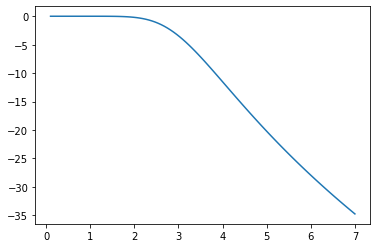

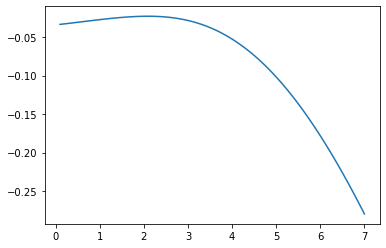

In [130]:
plt.figure()    
plt.plot(Talpha,np.real(deltas['s']) )  

fs=-2*k_C*hL_eta['s']-ERE_data['s'][0]+0.5*ERE_data['s'][1]*kcm**2-0.25*ERE_data['s'][2]*kcm**4
plt.figure()
plt.plot(Talpha,np.real(fs))

### Fig. 5 and 6

(0, 4500)

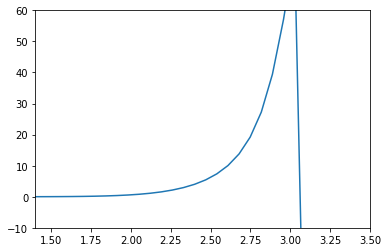

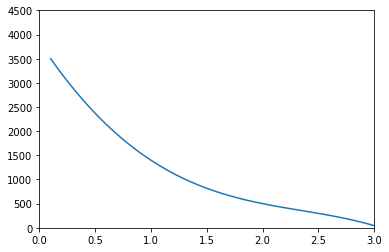

In [131]:
plt.figure()    
plt.plot(Talpha,np.real(deltas['p']) )  
plt.xlim([1.4,3.5])
plt.ylim([-10,60])

fp=-2*k_C*hL_eta['p']-ERE_data['p'][0]+0.5*ERE_data['p'][1]*kcm**2-0.25*ERE_data['p'][2]*kcm**4
plt.figure()
plt.plot(Talpha,np.real(fp))
plt.xlim([0,3])
plt.ylim([0,4500])

### Fig. 7 and 8

(-0.01, 0)

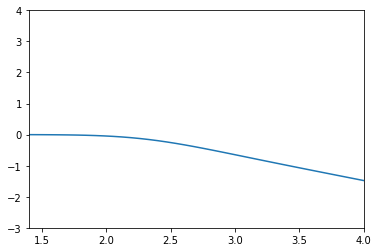

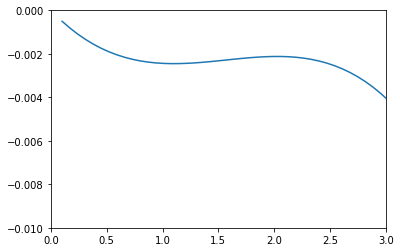

In [132]:
plt.figure()    
plt.plot(Talpha,np.real(deltas['d']) )  
plt.xlim([1.4,4])
plt.ylim([-3,4])

fd=-2*k_C*hL_eta['d']-ERE_data['d'][0]+0.5*ERE_data['d'][1]*kcm**2-0.25*ERE_data['d'][2]*kcm**4
plt.figure()
plt.plot(Talpha,np.real(fd)/fm**(-5))
plt.xlim([0,3])
plt.ylim([-0.01,0])